# 1 Author

**Student Name**: Yi Ju Lin  
**Student ID**: 210610424

# 2 Problem formulation
We'll use MLEnd London Sounds dataset which includes around 2500 audios to bulid a machine learning to classify whether the audio segment is indoors or outdoors.

What we have:
- 5 zip files which includes 2500 audios
- MLEndLS.csv



# 3 Machine Learning pipeline

The folloing steps are machine learning pipeline:
1. Enverionment setup
2. Audio files preparation
3. Transformation
4. Training model
5. Testing model
6. Audio labels: indoor or outdoor


# 4 Transformation stage
The following steps are transformation stage in this project:
1. Audio Files Preparation
2. Feature Extraction
3. Correlation of Feature
4. Normalization
5. Features

## 4.1 Feature Extraction
Feature extraction and the following steps, checking correlation of features, would be repeated to make sure we get useful features.

- Basic Features
 - power
 - pitch_mean
 - pitch_std
 - voiced_fr

- Additional Features
   - mfcc: Mel-frequency cepstral coefficients (MFCCs)
   - chroma_stft: Compute a chromagram from a waveform or power spectrogram.
   - rms: Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S

> Reference: https://github.com/musikalkemist/AudioSignalProcessingForML

## 4.2 Correlation of Feature
After picking up different features and getting some inferences from the graph, we choose above features which show on 4.1 step as our feature.

- power is highly positively related  to rms, which shows 0.96.
- mfcc is also quite highly correlated with rms, shows 0.63.
- chroma_stft is positively related to power.
- pitch_mean and pitech_std also imply strong relative.

Note that we can drop some highly negatively corelated based on correlation of features table so that we can choose better features for our model.

## 4.3 Min-Max Normalisation
Compared to Z-score normalization, Min-max normaliztion increases the accuracy ,and all features have the same scale.



# 5 Modelling
Based on the classification question, we adopr the following models:
- Support Vector Machines
- Raddom Forest Classifier
- k-Nearest Neighbors
- Logistic Regression
- Gradient Boosting
- Gaussian Naive Baye

# 6 Methodology
## 6.1 Training
To find the model which performs good enough, we split out datasets into training and validation sets. The following is the ration of our datasets to split:
- Training dataset (70%)
- Validation dataset (30%)

## 6.2 Testing
Test and ascess the best model with the best parameters. After finding the best model, we use the library sklearn.metrics to show our classificaiton report.
> Reference: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

## 6.3 Voting Classification
After training on numerous models and predicitng an output, we can choose the best model as our output.


# 7 Dataset
Because using the z-score normalization to normalize our dataset would decrease our accuracy, we only use Minmax dataset to traingin and testing our model.

# 8 Results

Carry out your experiments here, explain your results.

Environment set up - import python necessary libraries

In [ ]:
# connect goolge dirve
from google.colab import drive
drive.mount('/content/drive')

# mathematical functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# manage and download dataset
import os, sys, re, pickle, glob
import urllib.request
import zipfile

# manage audio data
import IPython.display as ipd
from tqdm import tqdm
import librosa
from sklearn.metrics import classification_report

Mounted at /content/drive


Run the following cell to check that the MLEnd_London_Sound folder contains the file 'MLEndLS.csv', 'MLEndLS_1.zip',
 'MLEndLS_2.zip',
 'MLEndLS_3.zip',
 'MLEndLS_4.zip',
 'MLEndLS_5.zip':

In [ ]:
path = '/content/drive/MyDrive/MLEnd_London_Sound'
os.listdir(path)

['MLEndLS.csv',
 'MLEndLS_1.zip',
 'MLEndLS_2.zip',
 'MLEndLS_3.zip',
 'MLEndLS_4.zip',
 'MLEndLS_5.zip',
 'sample']

Let's unzip the sample data:

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/MLEnd_London_Sound/sample'

# there are five zip ifle
for num in range(1,6):
  zip_path = '/content/drive/MyDrive/MLEnd_London_Sound/MLEndLS_{0}.zip'.format(num)
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


Let's check how many audios we have

In [ ]:
sample_path = '/content/drive/MyDrive/MLEnd_London_Sound/sample/*.wav'
files = glob.glob(sample_path)
num_files = len(files)
print('We have {} audios'.format(num_files))

We have 2498 audios


Upload the CSV file 'MLEndLS.csv'. Then run the next cell to load it into a Pandas DataFrame and print its contents.

In [ ]:
csv_path = '{}/MLEndLS.csv'.format(path)
MLENDLS_df = pd.read_csv(csv_path).set_index('file_id') 
NEW_MLENDLS_df = MLENDLS_df.drop(['0033.wav', '2206.wav']) # remove empty audios
NEW_MLENDLS_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


In [ ]:
# Verify the labels
NEW_MLENDLS_df['in_out'].value_counts()

outdoor    1317
indoor     1181
Name: in_out, dtype: int64

 ### Feature Extraction

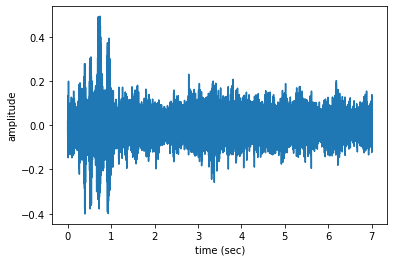

In [ ]:
n = 0
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

Check which file we are listening to is:

In [ ]:
file_path = files[n]
file_detail = NEW_MLENDLS_df.loc[files[n].split('/')[-1]]
print('The file path is : {}'.format(file_path))
print('The file detail is : \n{}'.format(file_detail))

The file path is : /content/drive/MyDrive/MLEnd_London_Sound/sample/1499.wav
The file detail is : 
area           campus
spot           ground
in_out         indoor
Participant       S76
Name: 1499.wav, dtype: object


In [ ]:
def getPitch(x,fs, winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['in_out']=='indoor'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    # other feature extraction
    mfcc = librosa.feature.mfcc(x, sr = fs) # Mel-frequency cepstral coefficients (MFCCs)
    chroma_stft = librosa.feature.chroma_stft(x, sr = fs) # Compute a chromagram from a waveform or power spectrogram.
    rms = librosa.feature.rms(x)
    xi = [power, pitch_mean, pitch_std, voiced_fr, np.mean(mfcc), np.mean(chroma_stft), np.mean(rms)]
    X.append(xi)
    y.append(yi)
    
  return np.array(X),np.array(y)

Let's implement the funciotn `getXy` for all files

In [ ]:
X,y = getXy(files, labels_file=NEW_MLENDLS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2498/2498 [1:14:22<00:00,  1.79s/it]


In [ ]:
# display all dataframe
col = ['power', 'pitch_mean', 'pitch_std', 'voiced_fr', 'mfcc','chroma_stft', 'rms']
features = pd.DataFrame(X, index = np.arange(0,len(X),1), columns = col)
features['indoor'] = y
features

,power,pitch_mean,pitch_std,voiced_fr,mfcc,chroma_stft,rms,indoor
0,0.013582,191.264966,21.315473,0.056291,0.650184,0.540409,0.107796,True
1,0.016052,126.443580,9.911017,0.056782,-8.298968,0.579022,0.116242,False
2,0.008356,236.657708,48.055864,0.100877,-1.126567,0.590075,0.076526,False
3,0.003179,0.000000,0.000000,0.000000,-1.772250,0.663131,0.045231,False
4,0.006184,162.432598,14.204691,0.091057,-1.387670,0.569720,0.063589,True
...,...,...,...,...,...,...,...,...
2493,0.011065,139.834136,8.740223,0.043011,-1.615270,0.482427,0.096384,True
2494,0.007997,0.000000,0.000000,0.000000,1.425864,0.655749,0.080292,False
2495,0.014900,156.126519,4.520193,0.028658,0.866153,0.535671,0.115147,True
2496,0.009474,107.086942,8.452984,0.067669,1.026893,0.618536,0.087264,False


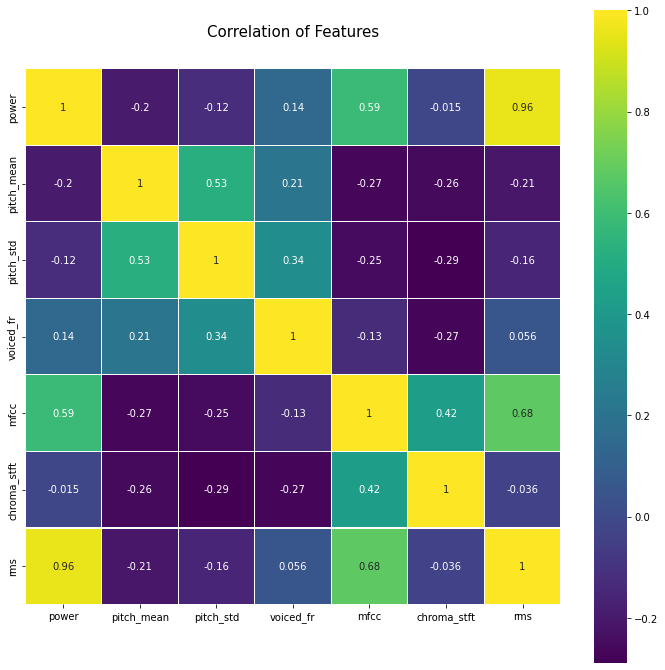

In [ ]:
# Correlation among features
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(features.iloc[:,:-1].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [ ]:
features.describe()

,power,pitch_mean,pitch_std,voiced_fr,mfcc,chroma_stft,rms
count,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,0.013476,152.615031,21.440425,0.085005,-1.339227,0.554161,0.095186
std,0.010126,77.823798,21.753945,0.079401,3.541049,0.076631,0.042253
min,0.000433,0.000000,0.000000,0.000000,-20.762302,0.212149,0.015081
25%,0.006571,114.553856,7.919292,0.044672,-3.097143,0.498745,0.063618
50%,0.010588,141.344408,15.342969,0.075938,-0.953007,0.550013,0.088795
75%,0.017707,199.383685,26.469406,0.102339,1.011941,0.613439,0.120766
max,0.081043,449.941853,142.306083,0.973684,7.444263,0.817069,0.272303


In [ ]:
# print out shape of X and y
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
# print('The labels vector is', y)

The shape of X is (2498, 7)
The shape of y is (2498,)


In [ ]:
# show how many indoor and outdoor sample we have
print(' The number of indoor recordings is ', np.count_nonzero(y))
print(' The number of outdoor recordings is ', y.size - np.count_nonzero(y))

 The number of indoor recordings is  1181
 The number of outdoor recordings is  1317


### Modeling

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
X_scaler = scaler.fit_transform(X)
# split the data
X_train, X_val, y_train, y_val = train_test_split(X_scaler, y, test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1748, 7), (750, 7), (1748,), (750,))

In [ ]:
models = [
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors = 5),
    LogisticRegression(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
]
scores = []
for model in models:
  model.fit(X_train, y_train)
  score = model.score(X_val, y_val)
  model_name = type(model).__name__

  
  y_test_predict = model.predict(X_train)
  y_val_predict = model.predict(X_val)

  training_accuracy = np.mean(y_test_predict == y_train)
  validation_accuracy = np.mean(y_val_predict == y_val)
  
  scores.append((model_name, training_accuracy, validation_accuracy))


scores_df = pd.DataFrame(scores,columns=['Classifier','Training Accuracy', 'Validation Accuracy'])
scores_df.sort_values(by = 'Validation Accuracy', axis = 0, ascending = False)


,Classifier,Training Accuracy,Validation Accuracy
0,SVC,0.740275,0.768000
1,RandomForestClassifier,1.000000,0.762667
5,GradientBoostingClassifier,0.828947,0.752000
3,LogisticRegression,0.703089,0.741333
2,KNeighborsClassifier,0.804920,0.728000
6,GaussianNB,0.681350,0.700000
4,DecisionTreeClassifier,1.000000,0.649333


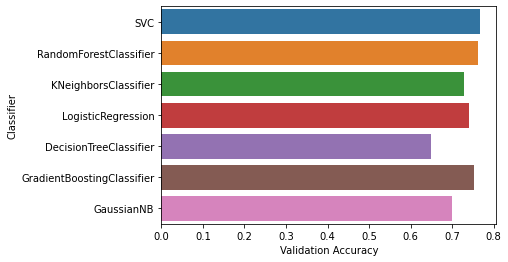

In [ ]:
sns.barplot(y='Classifier', x = 'Validation Accuracy', data = scores_df)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_val)

report_rfc = classification_report(y_val, pred)
print(report_rfc)

              precision    recall  f1-score   support

       False       0.79      0.77      0.78       396
        True       0.75      0.77      0.76       354

    accuracy                           0.77       750
   macro avg       0.77      0.77      0.77       750
weighted avg       0.77      0.77      0.77       750



After training and testing our datasets, we can classify our datasets as the following steps:
- Training the selection features by librosa which is a python package for music and audio analysis.
- Compared the different models train and print out the accuracy
- Find the best model and show the classificaiton report

# 9 Conclusions
The best classifier model we found is Support Vector Machines which shows the accuracy would be nearly 0.77